In [31]:
import os.path
from sklearn.externals import joblib
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
import numpy as np

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})

In [33]:
def load_data(path,file_name):
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

def load_custom_stop_words(path,file_name):
    custom_stop_words = []
    with open( os.path.join(path, file_name) , "r" ) as fin:
        for line in fin.readlines():
            custom_stop_words.append( line.strip() )
    print("Stopword list has %d entries" % len(custom_stop_words) )
    return custom_stop_words

def create_bag_of_words_matrix(documents_list,stop_words,min_term_freq):
    # use a custom stopwords list, set the minimum term-document frequency
    vectorizer = CountVectorizer(stop_words = stop_words, min_df = min_term_freq)
    A = vectorizer.fit_transform(documents_list)
    print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
    featurenames = vectorizer.get_feature_names()
    print("Vocabulary has %d distinct terms" % len(featurenames))
    return A,featurenames

def save_generated_matrix(matrix,column_list,titles,file_name):
    joblib.dump((matrix,column_list,titles), file_name)

def load_generated_matrix(file_name):
    (A,terms,titles) = joblib.load(file_name)
    print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
    return (A,terms,titles)

def create_tf_idf_matrix(documents_list,stop_words,min_term_freq):
    # we can pass in the same preprocessing parameters
    vectorizer = TfidfVectorizer(stop_words=stop_words, min_df = 20)
    A = vectorizer.fit_transform(documents_list)
    print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )
    featurenames = vectorizer.get_feature_names()
    print("Vocabulary has %d distinct terms" % len(featurenames))
    return A,featurenames

def create_nmf_model(matrix,number_of_topics):
    # create the model
    model = NMF( init="nndsvd", n_components=number_of_topics ) 
    # apply the model and extract the two factor matrices
    nmf = model.fit_transform(matrix)
    components = model.components_
    return nmf,components

def create_lsa_model(matrix,number_of_topics):
    model = TruncatedSVD(n_components = number_of_topics)
    lsa_matrix = model.fit_transform(matrix)
    return lsa_matrix,model.singular_values_,model.components_

def create_lda_model(matrix,number_of_topics):
    model=LatentDirichletAllocation(n_components=number_of_topics)
    lda_matrix = model.fit_transform(matrix)
    return lda_matrix,model.components_

In [34]:
min_term_freq=20 #define number of topics
number_of_topics=10
min_term_freq=20

In [35]:
# LSA Model
document_list,titles=load_data("","articles.txt")
stop_words=load_custom_stop_words("","stopwords.txt")
matrix,column_list=create_tf_idf_matrix(document_list,stop_words,min_term_freq)
save_generated_matrix(matrix,column_list,titles,"articles_bow_lsa.pkl")
A,terms,titles=load_generated_matrix("articles_bow_lsa.pkl")
W,E,H=create_lsa_model(A,number_of_topics)

('Total Number of Documents:', 4551)
Stopword list has 350 entries
Created 4551 X 10285 TF-IDF-normalized document-term matrix
Vocabulary has 10285 distinct terms
Loaded 4551 X 10285 document-term matrix


In [20]:
# LDA Model
document_list,titles=load_data("","articles.txt")
stop_words=load_custom_stop_words("","stopwords.txt")
matrix,column_list=create_tf_idf_matrix(document_list,stop_words,min_term_freq)
save_generated_matrix(matrix,column_list,titles,"articles_bow.pkl")
A,terms,titles=load_generated_matrix("articles_bow.pkl")
W,H=create_lda_model(A,number_of_topics)

('Total Number of Documents:', 4551)
Stopword list has 350 entries
Created 4551 X 10285 TF-IDF-normalized document-term matrix
Vocabulary has 10285 distinct terms
Loaded 4551 X 10285 document-term matrix


/home/northout/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [36]:
# NMF Model
document_list,titles=load_data("","articles.txt")
stop_words=load_custom_stop_words("","stopwords.txt")
matrix,column_list=create_tf_idf_matrix(document_list,stop_words,min_term_freq)
save_generated_matrix(matrix,column_list,titles,"articles_bow.pkl")
A,terms,titles=load_generated_matrix("articles_bow.pkl")
W,H=create_nmf_model(A,number_of_topics)

('Total Number of Documents:', 4551)
Stopword list has 350 entries
Created 4551 X 10285 TF-IDF-normalized document-term matrix
Vocabulary has 10285 distinct terms
Loaded 4551 X 10285 document-term matrix


In [37]:
W.shape, H.shape

((4551, 10), (10, 10285))

The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.

The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique keyword in the corpus vocabulary.

In [39]:
def top_ranked_topics( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

def find_top_topics(column_list, H, number_of_topics,top_terms):
    top_topics_list = []
    top_topics={}
    for topic_index in range(number_of_topics):
        top_topics_list.append(top_ranked_topics(column_list, H, topic_index,top_terms))
        top_topics["Topic-"+str(topic_index+1)]=", ".join(top_topics_list[topic_index])
    return top_topics

find_top_topics( column_list, H, 7, 10 )

{'Topic-1': u'eu, uk, brexit, britain, european, leave, europe, vote, referendum, trade',
 'Topic-2': u'trump, clinton, donald, republican, campaign, president, hillary, cruz, sanders, presidential',
 'Topic-3': u'film, films, movie, star, director, hollywood, actor, story, drama, cinema',
 'Topic-4': u'league, season, leicester, goal, premier, united, city, liverpool, game, ball',
 'Topic-5': u'bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds',
 'Topic-6': u'health, nhs, care, patients, mental, doctors, hospital, people, services, junior',
 'Topic-7': u'album, music, band, song, pop, songs, rock, love, sound, bowie'}

### Find number of Topics

In [23]:
document_list,titles=load_data("","articles.txt")
stop_words=load_custom_stop_words("","stopwords.txt")

('Total Number of Documents:', 4551)
Stopword list has 350 entries


In [24]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [25]:
import gensim
docgen = TokenGenerator( document_list, stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [26]:
def calculate_coherence( model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity([pair[0]], [pair[1]]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [27]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [28]:
topic_models = []
kmin,kmax=3,15
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


In [29]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/home/northout/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


KeyError: u"word 'eu' not in vocabulary"

In [70]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

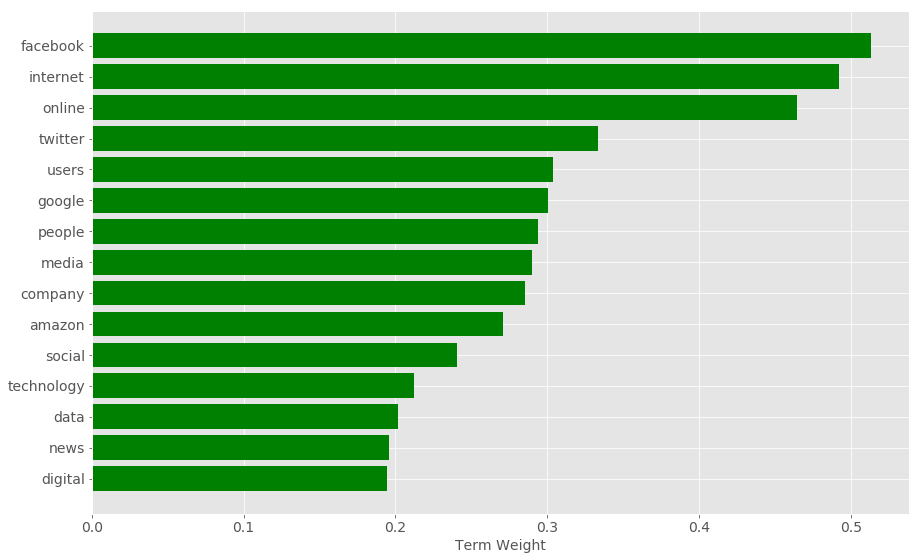

In [72]:
plot_top_term_weights( column_list, H, 7, 15 )

## Gensim Experimental Codes

In [ ]:
def find_number_topics_lda_model(doc_clean,kmin,kmax): 
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    coherences = []
    for i in range(kmin,kmax+1):
        # generate LDA model
        ldamodel = LdaModel(doc_term_matrix, num_topics=i, id2word = dictionary)
        cm = CoherenceModel(model=ldamodel, corpus=doc_term_matrix, coherence='u_mass')
        coherences.append( cm.get_coherence())  # get coherence value
    return coherences

def find_number_topics_lsa_model(doc_clean,kmin,kmax): 
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    coherences = []
    for i in range(kmin,kmax+1):
        # generate LDA model
        lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        cm = CoherenceModel(model=lsamodel, corpus=doc_term_matrix, coherence='u_mass')
        coherences.append( cm.get_coherence())  # get coherence value
    return coherences


kmin,kmax=4,15
words=10
coherence_list=find_number_topics_lsa_model(clean_text,kmin,kmax)
l=list(zip(range(kmin,kmax+1),coherence_list))
max(l,key=lambda item:item[1])